# Computer Vision Assignment 3
---

Semester: **Fall 2023**

Due date: **December 18th 2023, 11.59PM EST.**

## Instructions
---

You should perform this assignment using Google Colab.
* Before starting, clone this assignment using `File > Save a copy in Drive`.
* After you're done, go through the notebook and ensure that you have answered all questions.
* Finally, submit the ipynb `File > Download > Download .ipynb` on brightspace


In [9]:
%cd /content
!rm -rf assignment3
!wget https://cs.nyu.edu/~fergus/teaching/vision/assignment3.zip
!unzip assignment3 -d assignment3
%cd assignment3
!ls

/content
--2023-12-18 21:51:20--  https://cs.nyu.edu/~fergus/teaching/vision/assignment3.zip
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338457 (331K) [application/zip]
Saving to: ‘assignment3.zip.1’

assignment3.zip.1   100%[===================>] 330.52K  --.-KB/s    in 0.03s   

2023-12-18 21:51:20 (9.46 MB/s) - ‘assignment3.zip.1’ saved [338457/338457]

Archive:  assignment3.zip
  inflating: assignment3/book.pgm    
  inflating: assignment3/scene.pgm   
  inflating: assignment3/world.txt   
  inflating: assignment3/image.txt   
  inflating: assignment3/sfm_points.mat  
/content/assignment3
book.pgm  image.txt  scene.pgm	sfm_points.mat	world.txt


# Introduction
---

This assignment explores various methods for aligning images and feature extraction. There are three parts to the assignment:
1. [35 points] **Image alignment using RANSAC**:  
Solve for an affine transformation
between a pair of images using the RANSAC fitting algorithm.
2. [35 points] **Estimating Camera Parameters**:  
Using a set of 3D world points and
their 2D image locations, estimate the projection matrix P of a camera.
3. [30 points] **Structure from Motion**:  
Infer the 3D structure of an object, given a
set of images of the object.

# 1. Image Alignment
---

In this part of the assignment you will write a function that takes two images
as input and computes the affine transformation between them. The overall
scheme is as follows:
* Find local image regions in each image
* Characterize the local appearance of the regions
* Get set of putative matches between region descriptors in each image
* Perform RANSAC to discover best transformation between images

The first two stages can be performed using David Lowe’s SIFT feature
detector and descriptor representation. A Python version can be found in the
OpenCV-Python environment (https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html).

1. The two images you should match are `scene.pgm` and `book.pgm`, henceforth called image 1 and 2 respectively.
You should first run the SIFT detector over both images to produce a set
of regions, characterized by a 128d descriptor vector. Display these regions
on each picture to ensure that a satsifactory number of them have been
extracted. Please include the images in your submission.

2. The next step is to obtain a set of putative matches T. This should be
done as follows: for each descriptor in image 1, compute the closest neighbor
amongst the descriptors from image 2 using Euclidean distance. Spurious
matches can be removed by then computing the ratio of distances between
the closest and second-closest neighbor and rejecting any matches that are
above a certain threshold. To test the functioning of RANSAC, we want to
have some erroneous matches in our set, thus this threshold should be set to
a fairly slack value of 0.9. To check that your code is functioning correctly,
plot out the two images side-by-side with lines showing the potential matches.

3. The final stage, running RANSAC, should be performed as follows:
* _Repeat N times_ (where N is ∼100):
* Pick P matches at random from the total set of matches T. Since we
are solving for an affine transformation which has 6 degrees of freedom,
we only need to select P=3 matches.
* Construct a matrix A and vector b using the 3 pairs of points as described in lecture 12.
* Solve for the unknown transformation parameters q. In Python you
can use `linalg.solve`.
* Using the transformation parameters, transform the locations of all T
points in image 1. If the transformation is correct, they should lie close
to their pairs in image 2.
* Count the number of inliers, inliers being defined as the number of
transformed points from image 1 that lie within a radius of 10 pixels
of their pair in image 2.
* If this count exceeds the best total so far, save the transformation
parameters and the set of inliers.
* _End repeat_.
* Perform a final refit using the set of inliers belonging to the best transformation you found. This refit should use all inliers, not just 3 points
chosen at random.
* Finally, transform image 1 using this final set of transformation parameters, q. This can be done by first forming a homography matrix `H = [
q(1) q(2) q(3) ; q(4) q(5) q(6) ]`; and then using the
`cv2.warpAffine` command from OpenCV. If
you display this image you should find that the pose of the book in the
scene should correspond to its pose in image 2.

Make sure to include: (i) the transformed image 1 and (ii) the
values in the matrix `H`.

A. Stage 1


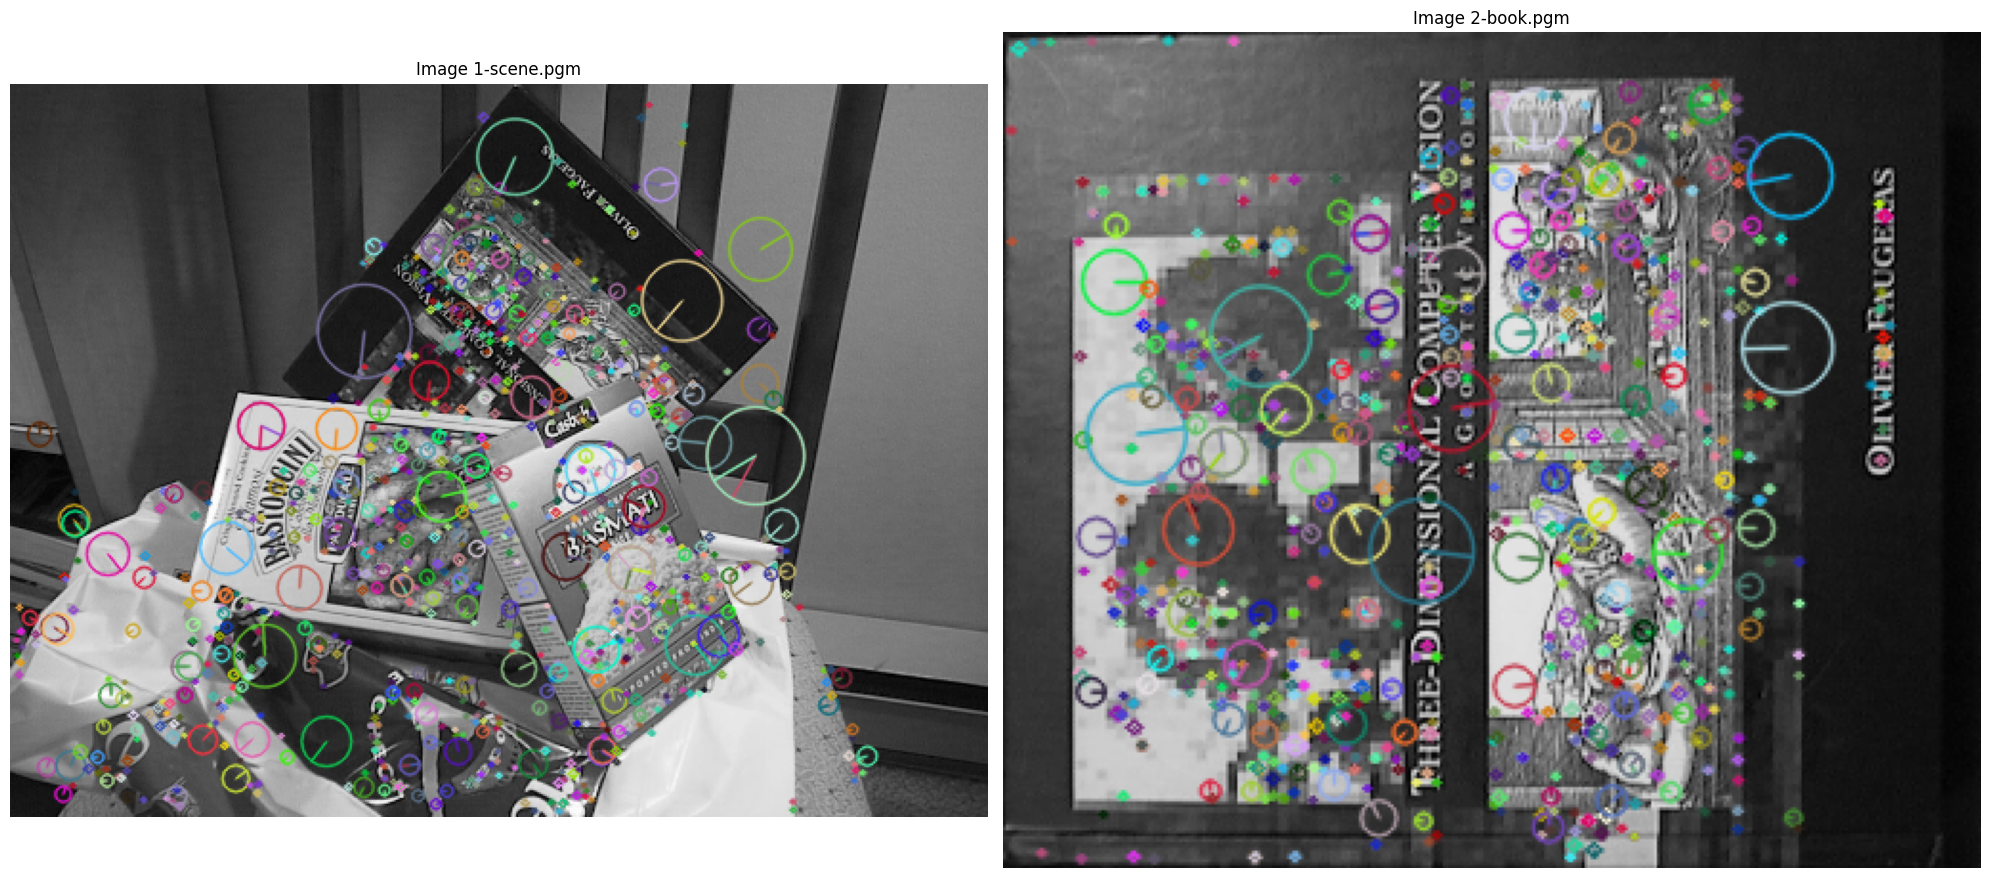

In [10]:

import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def stage1_show(image1, image2,keypoints1,keypoints2):
    fig, axes = plt.subplots(1, 2, figsize=(20, 15))
    img1=cv2.drawKeypoints(image1,keypoints1,0,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    axes[0].imshow(img1)
    axes[0].set_title('Image 1-scene.pgm')
    axes[0].axis('off')
    img2=cv2.drawKeypoints(image2,keypoints2,0,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    axes[1].imshow(img2)
    axes[1].set_title('Image 2-book.pgm')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()



image1_path='/content/assignment3/scene.pgm'
image2_path='/content/assignment3/book.pgm'
image1=cv2.imread(image1_path,cv2.IMREAD_GRAYSCALE)
image2=cv2.imread(image2_path,cv2.IMREAD_GRAYSCALE)
sift = cv2.SIFT_create()
keypoints1,descriptor1= sift.detectAndCompute(image1,None)
keypoints2,descriptor2= sift.detectAndCompute(image2,None)
stage1_show(image1,image2,keypoints1,keypoints2)


Stage-2

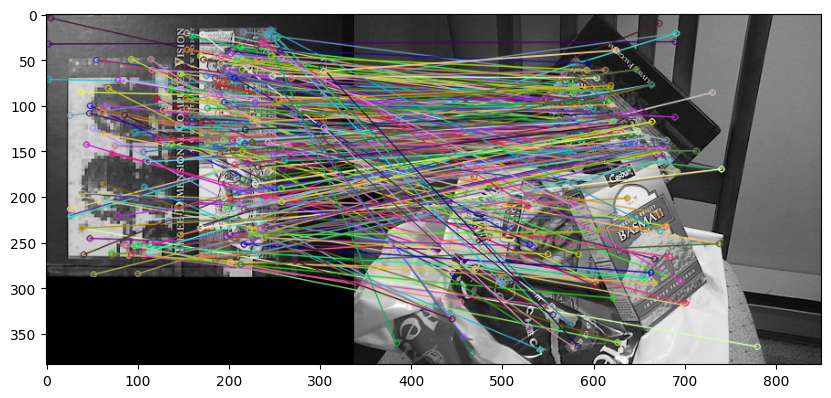

In [11]:
def stage2_show(img):
    fig, axes = plt.subplots(1, 1, figsize=(10, 15))
    axes.imshow(img)
    plt.show()

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptor2,descriptor1,k=2)
good = []
good_draw=[]
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good.append([m])
        good_draw.append(m)
img3 = cv2.drawMatchesKnn(image2,keypoints2,image1,keypoints1,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
stage2_show(img3)

Stage 3- RANSAC

max count: 114


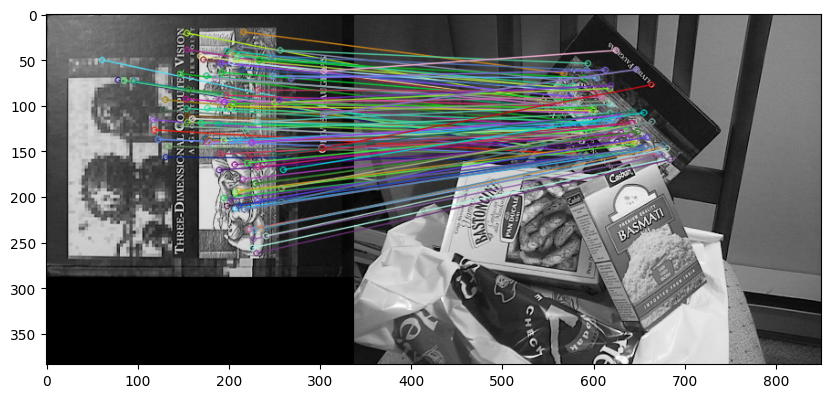

In [12]:
src_pts = np.float32([keypoints2[m.queryIdx].pt for m in good_draw])
dst_pts = np.float32([keypoints1[m.trainIdx].pt for m in good_draw])

N = 100

max_count = 0
best_inliers = 0
best_q = 0
for i in range(N):
    p = np.random.choice(range(len(src_pts)), 3)
    A = np.zeros([6,6])
    b = np.zeros([6])
    for j in range(3):
        A[2*j][0] = src_pts[p[j]][0]
        A[2*j][1] = src_pts[p[j]][1]
        A[2*j][2] = 1
        A[2*j+1][3] = src_pts[p[j]][0]
        A[2*j+1][4] = src_pts[p[j]][1]
        A[2*j+1][5] = 1
        b[2*j] = dst_pts[p[j]][0]
        b[2*j+1] = dst_pts[p[j]][1]
    try:
        q = np.linalg.solve(A, b)
    except:
        continue


    count = 0
    inliers = []
    for j in range(len(src_pts)):
        transform = np.dot(np.array([[src_pts[j][0],src_pts[j][1],1,0,0,0],[0,0,0,src_pts[j][0],src_pts[j][1],1]]),q)
        if np.linalg.norm(transform - dst_pts[j]) < 10:
            count += 1
            inliers.append(good_draw[j])
    if count>max_count:
        max_count = count
        best_inliers = inliers
        best_q = q
print('max count:',max_count)
matched = cv2.drawMatches(image2, keypoints2,image1, keypoints1, best_inliers, None, flags= 2)
plt.figure(figsize=(10,15))
plt.imshow(matched)

matrix H

In [13]:
H = np.array([[best_q[0], best_q[1], best_q[2]],
                  [best_q[3], best_q[4], best_q[5]],
                  [0, 0, 1]], dtype=np.float32)
print(H)
print("------------------------------------------------------------------")
H = best_q.reshape(2,3)
print(H)

[[  0.3889514    0.45547435 136.68872   ]
 [ -0.51115537   0.4036656  168.24529   ]
 [  0.           0.           1.        ]]
------------------------------------------------------------------
[[  0.3889514    0.45547434 136.68872362]
 [ -0.51115535   0.4036656  168.24528657]]


Transformed Image

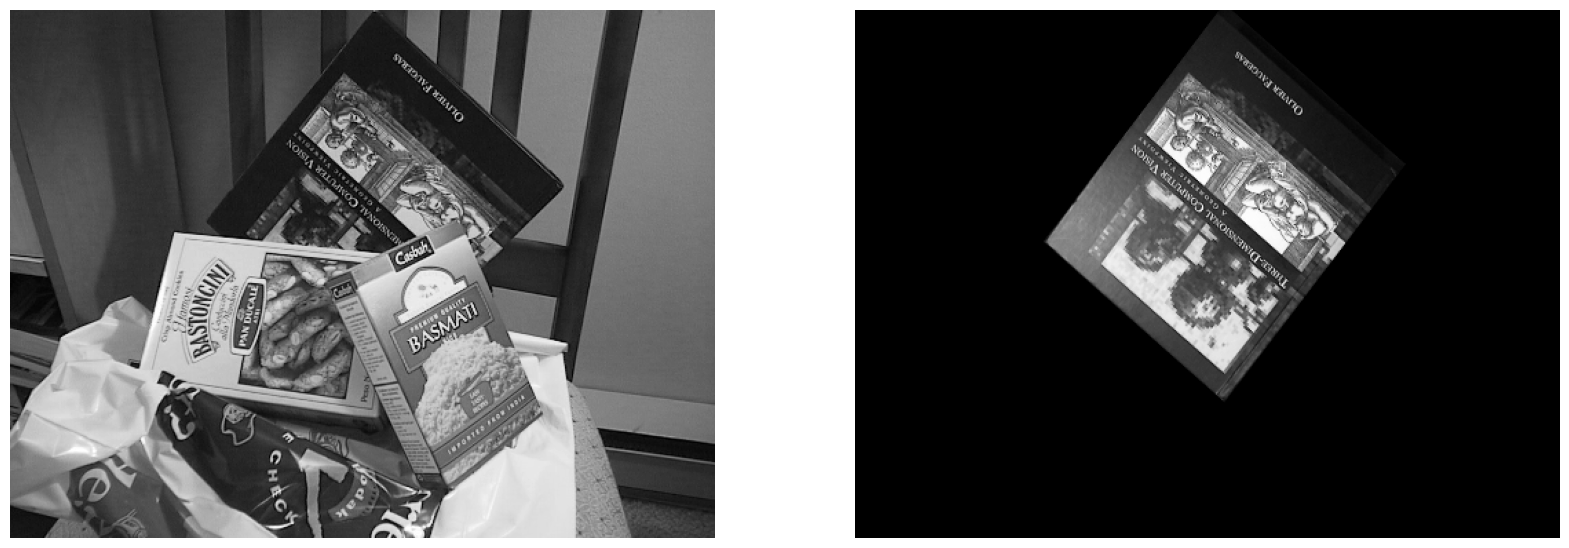

In [14]:
result = cv2.warpAffine(image2, best_q.reshape(2,3),(image1.shape[1],image1.shape[0]))
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image1,cmap='gray');
axs[0].axis('off');
axs[1].imshow(result,cmap='gray');
axs[1].axis('off');


# 2. Estimating the Camera Parameters
---

Here the goal is the compute the 3x4 camera matrix $P$ describing a pinhole camera given the coordinates of 10 world points and their corresponding
image projections. Then you will decompose $P$ into the intrinsic and extrinsic
parameters. You should write a simple script that works through the stages
below, printing out the important terms.

You will be working with two text files, `world.txt` and
`image.txt`. The first file contains the (X, Y, Z) values of 10 world points. The second file contains the (x, y) projections of those 10 points.

1. Find the 3x4 matrix $P$ that projects the world points $\mathbf{X}$ to the 10
image points $\mathbf{x}$. This should be done in the following steps:
  * Since $P$ is a homogeneous matrix, the world and image points (which
are 3D and 2D respectively) need to be converted into homogeneous
points by concatenating a 1 to each of them (thus becoming 4D and 3D
respectively).
  * We now note that $\mathbf{x} \times P\mathbf{X} = 0$, irrespective of the scale ambiguity. This allows us to setup a series of linear equations of the form:

    \begin{align}
    \begin{bmatrix}
    0^T & -w_i X_i^T & y_i X_i^T \\
    w_i X_i^T & 0^T & -x_i X_i^T \\
    -y_i X_i^T & x_i X_i^T & 0^T
    \end{bmatrix}
    \begin{bmatrix}
    P^1 \\
    P^2 \\
    P^3
    \end{bmatrix} = 0
    \end{align}

    for each correspondence $\mathbf{x}_i \leftrightarrow \mathbf{X}_i$, where $\mathbf{x}_i = (x_i, y_i, w_i)^T$. Here $w_i$ is the homogeneous coordinate, and $P^j$ is the $j$th row of $P$. But since the third row is a linear combination of the first two, we need only consider the first two rows for each correspondence $i$. Thus, you should form a 20 x 12 matrix $A$, each of the 10 correspondences contributing two rows. This yields $Ap = 0$, $p$ being the vector containing the entries of matrix $P$.

  * To solve for $p$, we need to impose an extra constraint to avoid the trivial solution $p = 0$. One simple one is to use $||p||_2 = 1$. This constraint is implicitly imposed when we compute the SVD of $A$. The value of
$p$ that minimizes $Ap$ subject to $||p||_2 = 1$ is given by the eigenvector
corresponding to the smallest singular value of $A$. To find this, compute
the SVD of $A$, picking this eigenvector and reshaping it into a 3 x 4
matrix $P$.

  * Verify your answer by re-projecting the world points $\mathbf{X}$ and checking that they are close to $\mathbf{x}$.

2. Now we have $P$, we can compute the world coordinates of the projection center of the camera $C$. Note that $P C = 0$, thus $C$ lies in the null
space of $P$, which can again be found with an SVD (the NumPy command is
`numpy.linalg.svd`). Compute the SVD of $P$ and pick the vector corresponding to this null-space. Finally, convert it back to inhomogeneous coordinates
and to yield the (X, Y, Z) coordinates. Your submission should contain the matrix $P$ and the value of $\tilde{C}$.

3. In the alternative route, we decompose $P$ into it’s constituent matrices. Recall from the lectures that $P = K[R|t]$. However, also, $t = −R\tilde{C}$, where $\tilde{C}$ is the inhomogeneous form of $C$. Since $K$ is upper triangular, use an RQ decomposition to factor $KR$ into the intrinsic parameters $K$ and a rotation matrix $R$. Then solve for $\tilde{C}$. Check that your answer agrees with the solution from the first method.

In [15]:
# TODO: Write your solution here

# Homogenous
# Build matrix A and vector P
# Run SVD, pick eigenvector
# Reproject
# Compute SVD
# Back to inhomogenous
# RQ Decomposition
# Solve for C_tilde
import scipy

world=np.loadtxt("/content/assignment3/world.txt")
image=np.loadtxt("/content/assignment3/image.txt")

# Make Homogenous points
world_append=np.ones((1, world.shape[1]))
image_append=np.ones((1, image.shape[1]))
world_hp=np.append(world,world_append,axis=0)
image_hp=np.append(image,image_append,axis=0)

assert world_hp.shape==(4,10)
assert image_hp.shape==(3,10)


#Build Matrix A
A=np.zeros([20,12])
for idx in range(image.shape[1]):
  A[idx*2][4:8]=-(image_hp[2][idx]*np.transpose(world_hp[:,idx]))
  A[idx*2][8:12]=(image_hp[1][idx]*np.transpose(world_hp[:,idx]))
  A[idx*2+1][0:4]=(image_hp[2][idx]*np.transpose(world_hp[:,idx]))
  A[idx*2+1][8:12]=-(image_hp[0][idx]*np.transpose(world_hp[:,idx]))
#print(A)

#Build P
U,S,V=np.linalg.svd(A)
P=V[-1:].reshape(3,4)
print(f"Matrix P\n {P}\n")

#Reproject
reproj=np.dot(P,world_hp)
reproj/=reproj[-1]
print(f"Reprojected:\n{reproj}\n")
print(f"Image points:\n{image_hp}")
print(f"\nProjected and x close ? {np.allclose(reproj,image_hp)}\n")


#Find C using SVD
U, S, V = np.linalg.svd(P)
C = V[-1]
C = C[:-1]/C[-1]
print(f"C using SVD\n {C}\n")

#Find C using RQ decomposition
R, Q = scipy.linalg.rq(P, mode='economic')
R = (Q.T)[:-1].T
t = (Q.T)[-1].T
C_tilde = np.linalg.solve(-R, t)
print(f"C using RQ\n {C_tilde}\n")

print(f"C_SVD and C_RQ are same? {np.allclose(C,C_tilde)}")

Matrix P
 [[-1.27000127e-01 -2.54000254e-01 -3.81000381e-01 -5.08000508e-01]
 [-5.08000508e-01 -3.81000381e-01 -2.54000254e-01 -1.27000127e-01]
 [-1.27000127e-01 -2.77555756e-17 -1.27000127e-01  1.11022302e-16]]

Reprojected:
[[ 5.11770701  5.5236545   7.16310171  5.22216628  5.60479614 13.59494885
   8.73452189  6.22433952  9.74763886  5.09031079]
 [ 4.76538441  3.87032917  7.35942066  4.4279585   4.67483648 10.05215495
   5.56420531  3.90821885  6.90423723  4.5508513 ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]]

Image points:
[[ 5.11770701  5.5236545   7.16310171  5.22216628  5.60479614 13.59494885
   8.73452189  6.22433952  9.74763886  5.09031079]
 [ 4.76538441  3.87032917  7.35942066  4.4279585   4.67483648 10.05215495
   5.56420531  3.90821885  6.90423723  4.5508513 ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]]

Projected and x close 

# 3. Structure from Motion
---

In this section you will code up an affine structure from motion algorithm, as
described in the slides of lecture 14. For more details, you can consult page
437 of the Hartley & Zisserman book.

Load the file `sfm_points.mat`. This
can be done using scipy (https://docs.scipy.org/doc/scipy/reference/io.html). The file contains a 2 x 600 x 10 matrix, holding
the $x, y$ coordinates of 600 world points projected onto the image plane
of the camera in 10 different locations. The points correspond, that is
`image_points[:, 1, :]` is the projection of the same 3D world point in the
10 frames. The points have been drawn randomly to lie on the surface of a
transparent 3D cube, which does not move between frames (i.e. the object is
static, only the camera moves). Try plotting out several frames and the cube
shaped structure should be apparent (the `plot3` command may be useful).
To simplify matters, we will only attempt an affine reconstruction, thus
the projection matrix of each camera $i$ will have following form:

\begin{align}
P^i =
\begin{bmatrix}
p_{11} & p_{12} & p_{12} & p_{14} \\
p_{21} & p_{22} & p_{23} & p_{24} \\
0      & 0      & 0      & 1
\end{bmatrix} =
\begin{bmatrix}
M^i & t^i \\
0   & 1
\end{bmatrix}
\end{align}

where $M^i$ is a 2 x 3 matrix and $t^i$ is a 2 x 1 translation vector.

So given $m = 10$ views and $n = 600$ points, having image locations $x_j^i$ where $j = 1, \dots , n$ and $i = 1, \dots , m$, we want to determine the affine camera matrices $M^i$, $t^i$ and 3D points $\mathbf{X}_j$ so that we minimize the reconstruction error:

$$\sum_{ij} || \mathbf{x}^i_j - (M^i \mathbf{X}_j + t^i) ||^2$$

We do this in the following stages:
* Compute the translations $t^i$ directly by computing the centroid of point
in each image $i$.
* Center the points in each image by subtracting off the centroid, so that
the points have zero mean.
* Construct the $2m$ x $n$ measurement matrix $W$ from the centered data.
* Perform an SVD decomposition of $W$ into $UDV^T$.
* The camera locations $M^i$ can be obtained from the first three columns
of $U$ multiplied by `D[:3, :3]`, the first three singular values.
* The 3D world point locations are the first three columns of $V$.
* You can verify your answer by plotting the 3D world points out using the `matplotlib` package, via the `plot3` command. The `rotate3d`
command will let you rotate the plot.

You should write a script to implement the steps above. The script should
print out the $M^i$ and $t^i$ for the first camera and also the 3D coordinates of the first 10 world points.

ti for the first camera:
 [2.36847579e-17 8.28966525e-17]

mi for first camera:
 [[-7.50914219  3.30837904 -3.71763726]
 [-4.53754376 -1.57773527  7.74574759]]

First 10 world points:
 [[ 0.00577163  0.06460628 -0.02497615]
 [ 0.0005761   0.06885363 -0.03458151]
 [-0.04293585  0.06330479  0.02861711]
 [ 0.04745038  0.04904207 -0.01257547]
 [-0.04210186  0.06789239  0.01175164]
 [ 0.05961964  0.0460518  -0.01438374]
 [ 0.00909167  0.06002049 -0.01229997]
 [ 0.01039489  0.04602065  0.03529275]
 [-0.02589081  0.05702972  0.03337375]
 [ 0.01745598  0.04054264  0.04731859]]



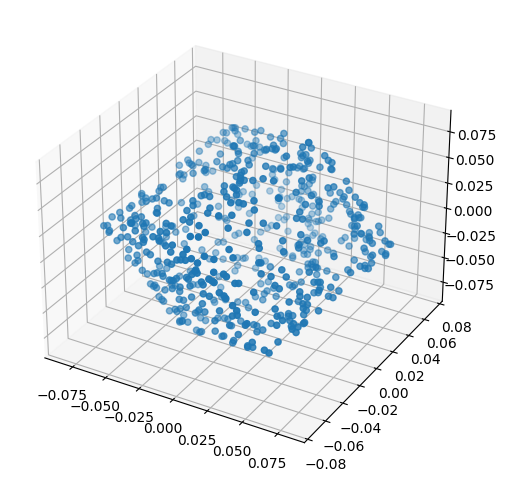

In [16]:
# TODO: Write your solution here

# Computing Centroid - Bullets 1, 2
# Build W - Bullet 3
# Do SVD, Pick Matrices (5) - Bullet 4, 5, 6
# Visualizing the solution - Bullet 7


import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
matrix = sio.loadmat("/content/assignment3/sfm_points.mat")
image_points=matrix['image_points']

# Compute translations
centroids=np.zeros((2,10))
for frame in range(10):
  x=np.sum(image_points[0,:,frame])/600
  y=np.sum(image_points[1,:,frame])/600
  centroids[:,frame]=np.array([x,y])

print(f"ti for the first camera:\n {centroids[:,0]}\n")

#Center points
centered_points=np.zeros((2,600,10))
for frame in range(10):
  centered_points[:,:,frame]=image_points[:,:,frame]-centroids[:,frame,np.newaxis]


# Compute W
W = np.zeros((20, 600))
for i in range(10):
    W[2*i, :] = centered_points[0, :, i]
    W[2*i+1, :] = centered_points[1, :, i]

# SVD Decomposition
U, D, V_T = np.linalg.svd(W)
V_T=V_T.T
D = D * np.identity(D.shape[0])

M = np.dot(U[:,:3], D[:3,:3])
print(f"mi for first camera:\n {M[:2]}\n")

world_points_3d = V_T[:,:3]
print(f"First 10 world points:\n {world_points_3d[:10]}\n")

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.scatter(world_points_3d[:,0], world_points_3d[:,1], world_points_3d[:,2])
plt.show()